# **Función de carga de las imagenes**

In [0]:
import os
import numpy as np
from tqdm import tqdm
from google.colab import drive
from PIL import Image
from cv2 import imread

drive.mount('/drive')
TYPES = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

#!ls '/drive/My Drive/dataset-BloodCells/dataset2-master/images/TEST_SIMPLE/'

def get_images(folder):
  X = []
  y = []
  for t in TYPES:
    path = folder + t
    if t == 'EOSINOPHIL':
      label = 0
    elif t == 'LYMPHOCYTE':
      label = 1
    elif t == 'MONOCYTE':
      label = 2
    else:
      label = 3

    for i in tqdm(os.listdir(path), desc = t):
      #image = imread(path+'/'+i)
      image = Image.open(path+'/'+i)
      if image != None:
        #i_resize = np.array(Image.fromarray(image).resize((32,32)))
        i_resize = np.asarray(image.resize((128,128)))
        X.append(i_resize)
        y.append(label)

  X = np.asarray(X)
  y = np.asarray(y)
  return X,y





Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## **Red Convolucional**

**Carga del corpus**

In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

num_classes = 4

## Carga de los datos ##
(x_train, y_train), (x_test, y_test) = get_images('/drive/My Drive/dataset-BloodCells/dataset2-master/images/TRAIN/'),  get_images('/drive/My Drive/dataset-BloodCells/dataset2-master/images/TEST/')

y_train, y_test = to_categorical(y_train,num_classes), to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('\n')
print(x_train.shape)
print(x_test.shape)

NEUTROPHIL: 100%|██████████| 624/624 [00:01<00:00, 517.00it/s]




(9957, 128, 128, 3)
(2487, 128, 128, 3)


***Pruebas***

[0. 0. 0. 1.]


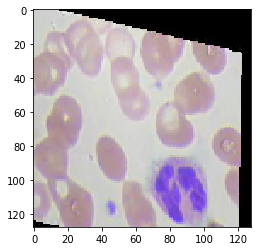

In [0]:
import matplotlib.pyplot as plt
import random
i = random.randint(0,2486)
im = x_test[i]
im_arr = np.asarray(im)
plt.imshow(im_arr)
print(y_test[i])

**Configuración de la red**

In [0]:
batch_size = 50
epochs = 75

###Resultados:###
#Batch-Norm y GN == a CIFAR#
#Batch Size probados: *(50, Test_a: 0,6639)* (75, Test_a: 0.5223) (100, Test_a: 0,6317)#
#Data Augmentation y LRA == a CIFAR: Test_a: 0,7021#
#Capas Convolucionales como CIFAR: Test_a: 0.8203#
#+ Dropout 0.5: lo caga bastante fuerte, fuera#
#Pasando imagenes de 64x64 y metiendo una capa mas de 1024 filtros: 0.8179#
#Pasando imagenes de 128x128 y metiendo una capa mas de 2048 filtros: 0.8335#

#DATA AUGMENTATION#
datagen = ImageDataGenerator(
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=20,
    zoom_range=[1.0,1.2],
    horizontal_flip=True)

#FUNCION QUE CREA LAS CAPAS DE CONVOLUCION#

def CBGN(model,fil_size,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (fil_size, fil_size), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (fil_size, fil_size), padding='same'))
  
  model.add(BN())
  model.add(GN(0.1))
  model.add(Activation('relu'))

  model.add(Conv2D(filters, (fil_size, fil_size), padding='same'))
  model.add(BN())
  model.add(GN(0.1))
  model.add(Activation('relu'))

  model.add(Conv2D(filters, (fil_size, fil_size), padding='same'))
  model.add(BN())
  model.add(GN(0.1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  
  return model

#CONFIGURACIÓN DE LA RED NEURONAL#
model = Sequential()

model=CBGN(model,3,32,x_train.shape[1:])
model=CBGN(model,3,64)
model=CBGN(model,3,128)
model=CBGN(model,3,256)
model=CBGN(model,3,512)
model=CBGN(model,3,1024)
model=CBGN(model,3,2048)

model.add(Flatten())
model.add(Dense(2048))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

## DESCENSO POR GRADIENTE Y COMPILACIÓN
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#LEARINING RATE ANNEALING#

def scheduler(epoch):
    if epoch < 25:
        return .01
    elif epoch < 50:
        return .001
    else:
        return .0001

set_lr = LRS(scheduler)

## TRAINING
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)

## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', round(scores[0],4))
print('Test accuracy:', round(scores[1],4))


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_64 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
gaussian_noise_64 (GaussianN (None, 128, 128, 32)      0         
_________________________________________________________________
activation_70 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_65 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
gaussian_noise_65 (GaussianN (None, 128, 128, 32)     